In [1]:
pip install geopy

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

usage: conda-script.py [-h] [-V] command ...
conda-script.py: error: unrecognized arguments: # uncomment this line if you haven't completed the Foursquare API lab


Libraries imported.


In [60]:
CLIENT_ID = 'FM32E0UU4KR1WU4VZIG1F5G1J2XFMKEGNF52UGPTSQ1J1CF1' # your Foursquare ID
CLIENT_SECRET = 'R5SUZ4FBHNDVUMHP15ZKFIKI5VCQBLGPYSFGZY2LYQXMILX2' # your Foursquare Secret
ACCESS_TOKEN = 'RMQPZQ4EHQ20C1KS35TUHATXYQ5S3PX50CJDBF24FNBOYZGH' # your FourSquare Access Token
VERSION = '20180604'
LIMIT = 30
radius = 1000
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: FM32E0UU4KR1WU4VZIG1F5G1J2XFMKEGNF52UGPTSQ1J1CF1
CLIENT_SECRET:R5SUZ4FBHNDVUMHP15ZKFIKI5VCQBLGPYSFGZY2LYQXMILX2


### Get geo location of address using Foursquare API

In [4]:
def getLocation(address):
    geolocator = Nominatim(user_agent="ny_explorer")
    locatidn = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

### Get venues in Dataframe form

In [5]:
def getVenues(lat,lng):    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    
    for row in venue_data:
        try:
            venue_id = row['venue']['id']
            venue_name = row['venue']['name']
            venue_category = row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

### Get venue Details

In [6]:
def getVenueDetails(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data = results['response']['venue']
    venue_details = []
    
    try:
        venue_id = venue_data['id']
        venue_name = venue_data['name']
        venue_likes = venue_data['likes']['count']
        venue_rating = venue_data['rating']
        venue_tips = venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

### Get New York City Data

In [9]:
def getNYC():
    
    url = 'https://cocl.us/new_york_dataset'
    resp = requests.get(url).json()
    
    # all data is present in features label
    features = resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [10]:
NYC = getNYC()
NYC.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [11]:
NYC.shape

(306, 4)

*There are 306 different Neighborhoods in New York to select from*

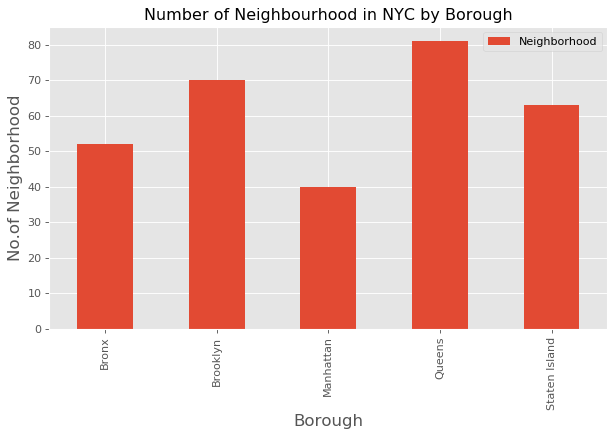

In [13]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 80)
plt.title('Number of Neighbourhood in NYC by Borough')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No.of Neighborhood', fontsize=15)
NYC.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
plt.legend()

plt.show()

*Queens is the most densely populated borough in New York City with 80 neighborhoods*

## prepare neighborhood list that contains indian restaurant

In [19]:
column_names = ['Borough', 'Neighborhood', 'ID','Name']
indian_rest_ny = pd.DataFrame(columns=column_names)
count=1

for row in NYC.values.tolist():
    Borough, Neighborhood, Latitude, Longitude = row
    venues = getVenues(Latitude,Longitude)
    indian_resturants = venues[venues['Category'] == 'Indian Restaurant']
    
    print('(',count,'/',len(NYC),')','Indian Resturants in '+Neighborhood+', '+Borough+':'+str(len(indian_resturants)))
    for resturant_detail in indian_resturants.values.tolist():
        id, name , category=resturant_detail
        indian_rest_ny = indian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Indian Resturants in Wakefield, Bronx:0
( 2 / 306 ) Indian Resturants in Co-op City, Bronx:0
( 3 / 306 ) Indian Resturants in Eastchester, Bronx:0
( 4 / 306 ) Indian Resturants in Fieldston, Bronx:0
( 5 / 306 ) Indian Resturants in Riverdale, Bronx:0
( 6 / 306 ) Indian Resturants in Kingsbridge, Bronx:0
( 7 / 306 ) Indian Resturants in Marble Hill, Manhattan:0
( 8 / 306 ) Indian Resturants in Woodlawn, Bronx:1
( 9 / 306 ) Indian Resturants in Norwood, Bronx:0
( 10 / 306 ) Indian Resturants in Williamsbridge, Bronx:0
( 11 / 306 ) Indian Resturants in Baychester, Bronx:0
( 12 / 306 ) Indian Resturants in Pelham Parkway, Bronx:0
( 13 / 306 ) Indian Resturants in City Island, Bronx:0
( 14 / 306 ) Indian Resturants in Bedford Park, Bronx:0
( 15 / 306 ) Indian Resturants in University Heights, Bronx:0
( 16 / 306 ) Indian Resturants in Morris Heights, Bronx:0
( 17 / 306 ) Indian Resturants in Fordham, Bronx:0
( 18 / 306 ) Indian Resturants in East Tremont, Bronx:0
( 19 / 306 ) Ind

( 143 / 306 ) Indian Resturants in Maspeth, Queens:0
( 144 / 306 ) Indian Resturants in Ridgewood, Queens:0
( 145 / 306 ) Indian Resturants in Glendale, Queens:0
( 146 / 306 ) Indian Resturants in Rego Park, Queens:0
( 147 / 306 ) Indian Resturants in Woodhaven, Queens:0
( 148 / 306 ) Indian Resturants in Ozone Park, Queens:0
( 149 / 306 ) Indian Resturants in South Ozone Park, Queens:1
( 150 / 306 ) Indian Resturants in College Point, Queens:0
( 151 / 306 ) Indian Resturants in Whitestone, Queens:0
( 152 / 306 ) Indian Resturants in Bayside, Queens:2
( 153 / 306 ) Indian Resturants in Auburndale, Queens:0
( 154 / 306 ) Indian Resturants in Little Neck, Queens:0
( 155 / 306 ) Indian Resturants in Douglaston, Queens:0
( 156 / 306 ) Indian Resturants in Glen Oaks, Queens:3
( 157 / 306 ) Indian Resturants in Bellerose, Queens:0
( 158 / 306 ) Indian Resturants in Kew Gardens Hills, Queens:0
( 159 / 306 ) Indian Resturants in Fresh Meadows, Queens:0
( 160 / 306 ) Indian Resturants in Briarw

( 280 / 306 ) Indian Resturants in Fulton Ferry, Brooklyn:0
( 281 / 306 ) Indian Resturants in Vinegar Hill, Brooklyn:0
( 282 / 306 ) Indian Resturants in Weeksville, Brooklyn:0
( 283 / 306 ) Indian Resturants in Broadway Junction, Brooklyn:1
( 284 / 306 ) Indian Resturants in Dumbo, Brooklyn:0
( 285 / 306 ) Indian Resturants in Manor Heights, Staten Island:0
( 286 / 306 ) Indian Resturants in Willowbrook, Staten Island:0
( 287 / 306 ) Indian Resturants in Sandy Ground, Staten Island:0
( 288 / 306 ) Indian Resturants in Egbertville, Staten Island:0
( 289 / 306 ) Indian Resturants in Roxbury, Queens:0
( 290 / 306 ) Indian Resturants in Homecrest, Brooklyn:0
( 291 / 306 ) Indian Resturants in Middle Village, Queens:0
( 292 / 306 ) Indian Resturants in Prince's Bay, Staten Island:0
( 293 / 306 ) Indian Resturants in Lighthouse Hill, Staten Island:0
( 294 / 306 ) Indian Resturants in Richmond Valley, Staten Island:0
( 295 / 306 ) Indian Resturants in Malba, Queens:0
( 296 / 306 ) Indian Re

In [20]:
indian_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot
1,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird
2,Brooklyn,Brighton Beach,4af0d31bf964a5207ddf21e3,Pak Nasheman
3,Brooklyn,East Flatbush,512a9ea9e4b004fb8eeb84e5,Silver Krust
4,Brooklyn,Prospect Lefferts Gardens,4bb93b70cf2fc9b6fe64a002,Gandhi Fine Indian Cuisine


In [21]:
indian_rest_ny.shape

(48, 4)

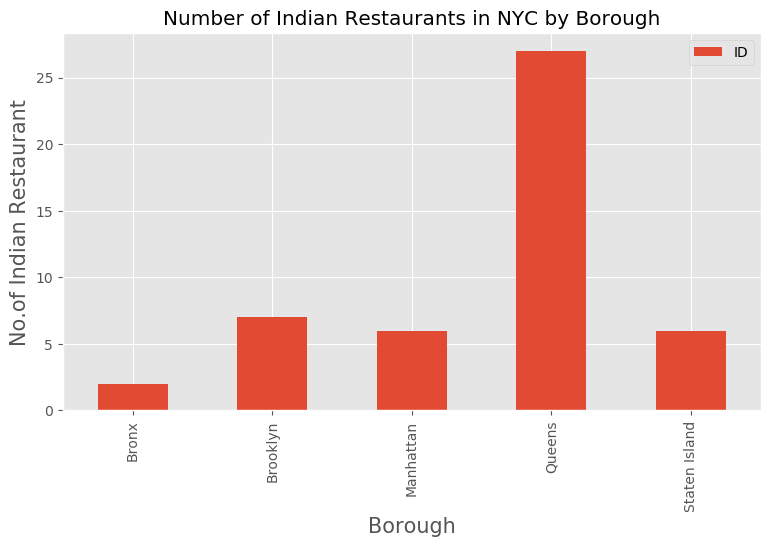

In [22]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 100)
plt.title('Number of Indian Restaurants in NYC by Borough')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No.of Indian Restaurant', fontsize=15)
indian_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
plt.legend()

plt.show()

*It is noted that Queens has the highest number of Indian Restaurants. about 27 Restaurant*

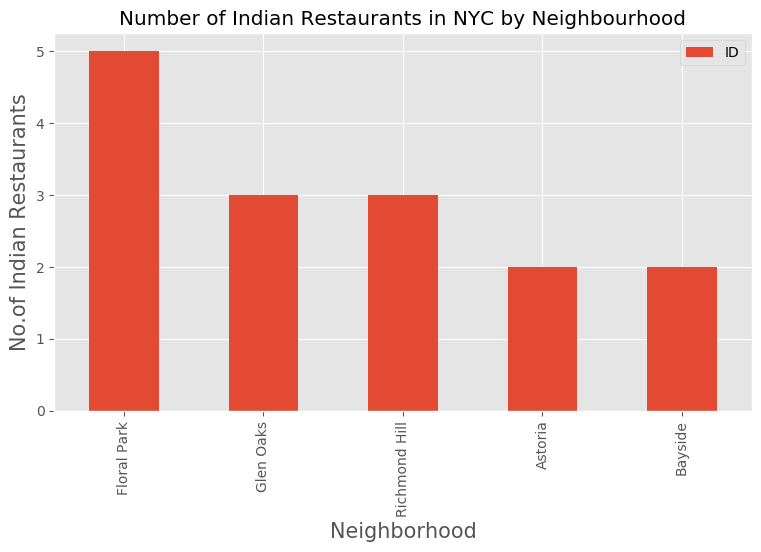

In [23]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 100)
plt.title('Number of Indian Restaurants in NYC by Neighbourhood')
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('No.of Indian Restaurants', fontsize=15)
indian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
plt.legend()

plt.show()

*Floral Park in Queens has the most Indian Resturants with a total count of 5.*

## Get Deatails About indian restaurants

In [61]:
column_names = ['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
restStats = pd.DataFrame(columns=column_names)
count=1

for row in indian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details = getVenueDetails(ID)
        print(venue_details)
        id,name,likes,rating,tips = venue_details.values.tolist()[0]
    except (IndexError, KeyError) as e:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(indian_rest_ny),')','processed')
    if id != 0:
        restStats = restStats.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID        Name  Likes  Rating  Tips
0  4c0448d9310fc9b6bf1dc761  Curry Spot      5     7.4    10
( 1 / 48 ) processed
                         ID         Name  Likes  Rating  Tips
0  551b7f75498e86c00a0ed2e1  Hungry Bird      8     6.7     3
( 2 / 48 ) processed
                         ID          Name  Likes  Rating  Tips
0  4af0d31bf964a5207ddf21e3  Pak Nasheman      9     7.7     4
( 3 / 48 ) processed
                         ID          Name  Likes  Rating  Tips
0  512a9ea9e4b004fb8eeb84e5  Silver Krust     13     8.3     3
( 4 / 48 ) processed
                         ID                        Name  Likes  Rating  Tips
0  4bb93b70cf2fc9b6fe64a002  Gandhi Fine Indian Cuisine     83     8.7    49
( 5 / 48 ) processed
                         ID           Name  Likes  Rating  Tips
0  4f6cae2ee4b0d4a5afcef5c0  Delhi Heights     22     8.0     8
( 6 / 48 ) processed
                         ID             Name  Likes  Rating  Tips
0  5539753f498edbace4746b67 

In [62]:
restStats.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot,5,7.4,10
1,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird,8,6.7,3
2,Brooklyn,Brighton Beach,4af0d31bf964a5207ddf21e3,Pak Nasheman,9,7.7,4
3,Brooklyn,East Flatbush,512a9ea9e4b004fb8eeb84e5,Silver Krust,13,8.3,3
4,Brooklyn,Prospect Lefferts Gardens,4bb93b70cf2fc9b6fe64a002,Gandhi Fine Indian Cuisine,83,8.7,49


In [63]:
restStats.shape

(45, 7)

In [64]:
restStats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 7 columns):
Borough         45 non-null object
Neighborhood    45 non-null object
ID              45 non-null object
Name            45 non-null object
Likes           45 non-null object
Rating          45 non-null float64
Tips            45 non-null object
dtypes: float64(1), object(6)
memory usage: 2.6+ KB


In [65]:
restStats['Name'] = restStats['Name'].astype('str')

### The most liked restaurants

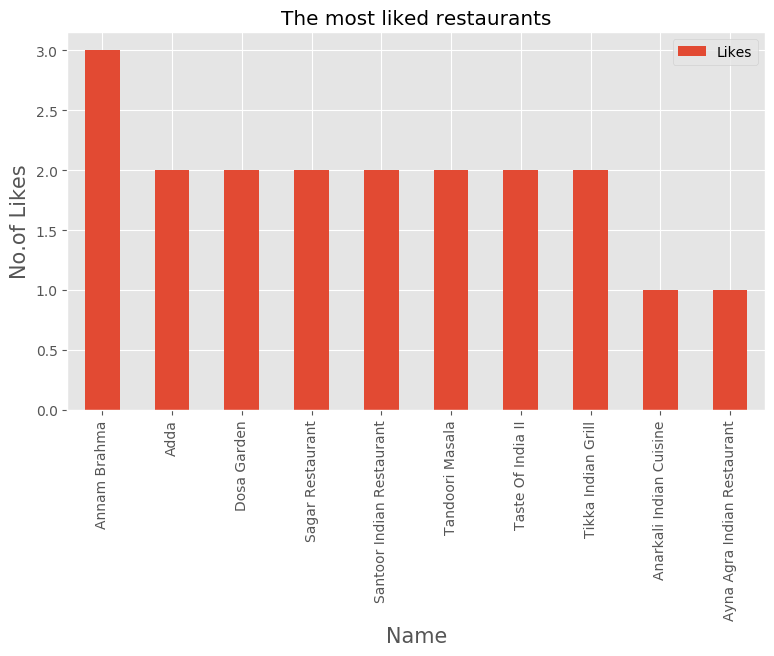

In [66]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 100)
plt.title('The most liked restaurants')
plt.xlabel('Restaurants', fontsize = 15)
plt.ylabel('No.of Likes', fontsize=15)
restStats.groupby('Name').count()['Likes'].nlargest(10).plot(kind='bar')
plt.legend()

plt.show()

### The most liked Neighbourhood

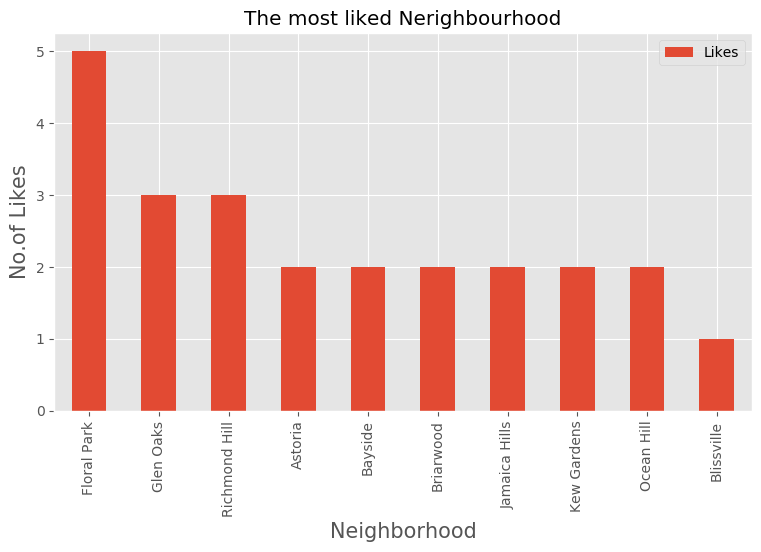

In [69]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 100)
plt.title('The most liked Nerighbourhood')
plt.xlabel('Restaurants', fontsize = 15)
plt.ylabel('No.of Likes', fontsize=15)
restStats.groupby('Neighborhood').count()['Likes'].nlargest(10).plot(kind='bar')
plt.legend()

plt.show()

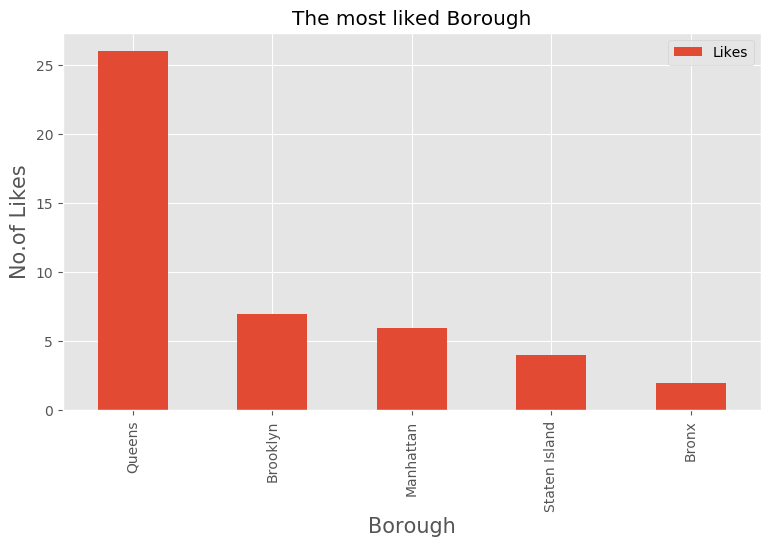

In [76]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 100)
plt.title('The most liked Borough')
plt.xlabel('Restaurants', fontsize = 15)
plt.ylabel('No.of Likes', fontsize=15)
restStats.groupby('Borough').count()['Likes'].nlargest(5).plot(kind='bar')
plt.legend()

plt.show()

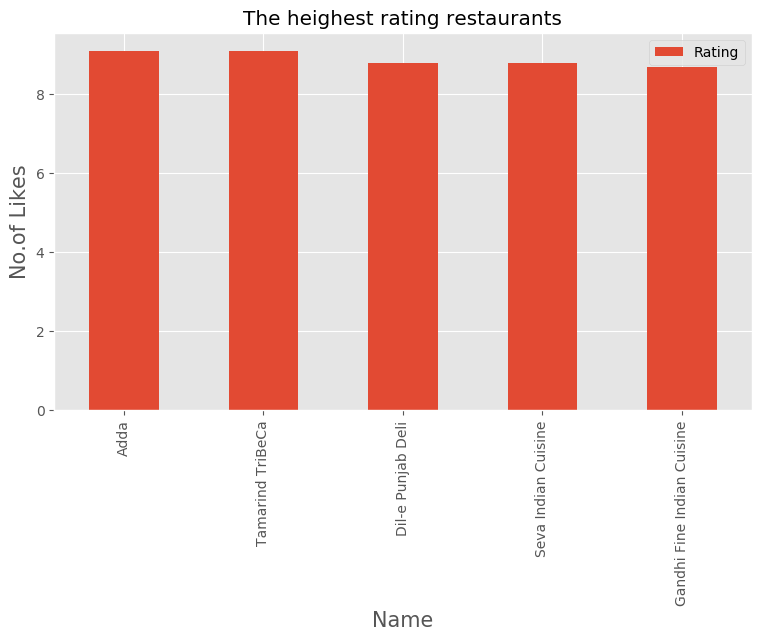

In [78]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 100)
plt.title('The heighest rating restaurants')
plt.xlabel('Restaurants', fontsize = 15)
plt.ylabel('No.of Likes', fontsize=15)
restStats.groupby('Name').mean()['Rating'].nlargest(5).plot(kind='bar')
plt.legend()

plt.show()

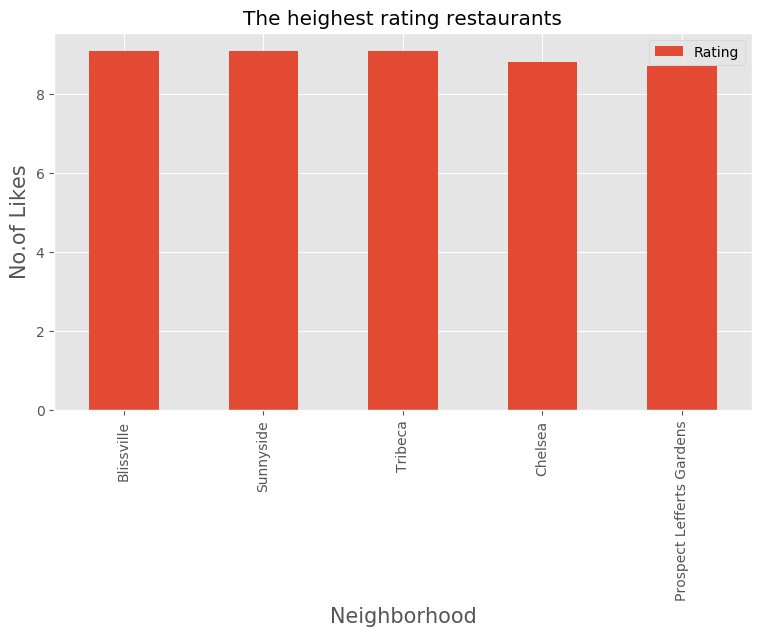

In [81]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 100)
plt.title('The heighest rating Neighborhood')
plt.xlabel('Restaurants', fontsize = 15)
plt.ylabel('No.of Likes', fontsize=15)
restStats.groupby('Neighborhood').mean()['Rating'].nlargest(5).plot(kind='bar')
plt.legend()

plt.show()

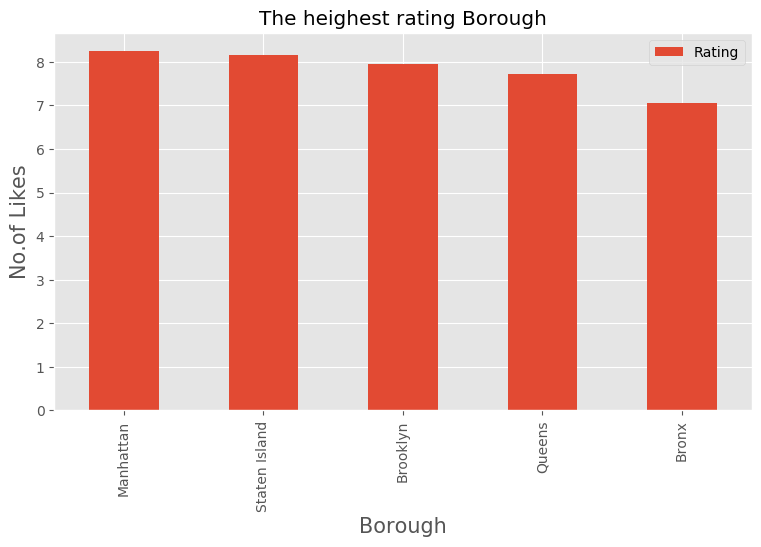

In [82]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 100)
plt.title('The heighest rating Borough')
plt.xlabel('Restaurants', fontsize = 15)
plt.ylabel('No.of Likes', fontsize=15)
restStats.groupby('Borough').mean()['Rating'].nlargest(5).plot(kind='bar')
plt.legend()

plt.show()

# Plotting the map
###### All the neighborhoods with average rating greater or equal 8.0 to be visualized on map

In [95]:
stats=restStats.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
stats.columns=['Neighborhood','Average Rating']
stats

,Neighborhood,Average Rating
0,Astoria,8.550000
1,Bayside,8.050000
2,Blissville,9.100000
3,Chelsea,8.800000
4,East Flatbush,8.300000
5,Floral Park,8.166667
6,Grant City,8.200000
7,Holliswood,8.200000
8,New Brighton,8.100000
9,New Dorp,8.200000


In [96]:
nStats = pd.merge(stats, NYC, on='Neighborhood')
nStats

,Neighborhood,Average Rating,Borough,Latitude,Longitude
0,Astoria,8.550000,Queens,40.768509,-73.915654
1,Bayside,8.050000,Queens,40.766041,-73.774274
2,Blissville,9.100000,Queens,40.737251,-73.932442
3,Chelsea,8.800000,Manhattan,40.744035,-74.003116
4,Chelsea,8.800000,Staten Island,40.594726,-74.189560
5,East Flatbush,8.300000,Brooklyn,40.641718,-73.936103
6,Floral Park,8.166667,Queens,40.741378,-73.708847
7,Grant City,8.200000,Staten Island,40.576216,-74.105856
8,Holliswood,8.200000,Queens,40.720957,-73.767142
9,New Brighton,8.100000,Staten Island,40.640615,-74.087017


In [97]:
ny_map = folium.Map(location=(40.693943, -73.985880), zoom_start=12)
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in nStats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [98]:
nStats['Label'] = nStats['Neighborhood']+', '+nStats['Borough']+'('+nStats['Average Rating'].map(str)+')'

In [100]:
# add pop-up text to each marker on the map
for lat, lng, label in nStats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)